<a href="https://colab.research.google.com/github/ahmedhas32/Data-science-projects/blob/master/Case_Study_SEM_data_analyst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandasql

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandasql as ps
import statsmodels.api as sm
from scipy.stats import skew
import csv as csv
from sklearn.preprocessing import StandardScaler
from scipy.stats import ks_2samp


import warnings
warnings.filterwarnings("ignore")

In [0]:
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.decomposition import FactorAnalysis , PCA

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
from sklearn.preprocessing import LabelEncoder

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
part_1_data = pd.read_excel("/content/drive/My Drive/Data set for Part One - Business Metrics.xlsx")

In [0]:
part_2_data = pd.read_excel("/content/drive/My Drive/Data set for Part Two - A B Testing.xlsx")

## 2. Business Metrics

Let's first have a brief about datatypes , and presence of NaN values

In [9]:
part_1_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 14 columns):
Keyword ID           478 non-null int64
Keyword Category     478 non-null object
Country              478 non-null object
Device               478 non-null object
Cost                 478 non-null float64
Clicks               478 non-null int64
Revenue              478 non-null float64
RPC                  0 non-null float64
CPC                  478 non-null float64
ROAS                 478 non-null float64
Total Clickouts      478 non-null int64
Tracked Clickouts    478 non-null int64
Tracking Coverage    478 non-null float64
Booking Value        478 non-null int64
dtypes: float64(6), int64(5), object(3)
memory usage: 52.4+ KB


#### Since we find columns names that include spaces , it is better to rename columns

In [0]:
part_1_data.columns=['keyword_id' ,'keyword_category' ,'country' , 'device' ,'cost' ,'clicks' , 'revenue' ,'RPC' ,'CPC' , 'ROAS' ,'total_clickouts' ,'tracked_clickouts' ,'tracking_coverage' ,'booking_value']

Here, we find that all variables are in the proper data types , except keyword_id which is an ID variable so it is better to be converted to object data type

In [0]:
part_1_data['keyword_id'] = part_1_data['keyword_id'].astype('object')

Also we find that 'RPC' is all NaN values , and this is logical , since calculating it is the first question :):):)

In [0]:
part_1_data.drop(columns=['RPC'] , inplace=True)

Well, let's have a brief about numeric columns

In [13]:
part_1_data.describe(include=['int' , 'float']).T

,count,mean,std,min,25%,50%,75%,max
cost,478.0,409.357552,510.001194,161.150000,192.580000,254.925000,402.797500,5714.330000
clicks,478.0,432.062762,940.962438,32.000000,126.000000,248.000000,472.250000,17306.000000
revenue,478.0,373.196025,584.998029,33.880000,132.397500,234.190000,430.400000,9912.340000
CPC,478.0,1.583785,1.114576,0.157548,0.728995,1.310063,2.090618,5.852424
ROAS,478.0,0.944025,0.588439,0.164187,0.517123,0.776681,1.170279,4.101981
total_clickouts,478.0,303.778243,722.754712,16.000000,90.000000,167.500000,309.250000,13989.000000
tracked_clickouts,478.0,177.163180,531.318926,3.000000,41.250000,76.000000,169.750000,10587.000000
tracking_coverage,478.0,0.520281,0.149161,0.052632,0.414789,0.533124,0.631627,0.942308
booking_value,478.0,807.102510,1161.066144,0.000000,0.000000,388.500000,1077.250000,9748.000000


In [14]:
part_1_data.describe(include='object')

,keyword_id,keyword_category,country,device
count,478,478,478,478
unique,367,4,4,2
top,15043640,A,US,phone
freq,6,460,254,285


In [15]:
part_1_data.head()

,keyword_id,keyword_category,country,device,cost,clicks,revenue,CPC,ROAS,total_clickouts,tracked_clickouts,tracking_coverage,booking_value
0,12136471,A,US,desktop,5714.33,1172,2013.58,4.875708,0.352374,926,515,0.556156,9748
1,91730045,A,Spain,phone,4691.94,17306,9912.34,0.271116,2.112631,13989,10587,0.756809,8313
2,119124300,A,US,phone,4671.65,2700,3924.61,1.730241,0.840091,1717,554,0.322656,4901
3,101751504,A,US,phone,2771.68,1947,2789.86,1.423564,1.006559,1247,432,0.346431,1778
4,12136471,A,US,phone,2743.42,1507,1999.14,1.820451,0.728704,869,441,0.507480,5658


###  1. Calculate the Revenue per Click (RPC) for every keyword. 

### What are the top performing keywords?

In [0]:
total_clicks_Revenue = part_1_data.groupby(['keyword_id'])['revenue' , 'clicks'].agg(sum)

In [0]:
total_clicks_Revenue.columns=['revenue_per_keyword','clicks_per_keyword']

In [0]:
total_clicks_Revenue['RPC'] = total_clicks_Revenue['revenue_per_keyword']/total_clicks_Revenue['clicks_per_keyword']

In [19]:
np.round(total_clicks_Revenue.sort_values(by=['RPC'] , ascending=False).head(10),2)['RPC']

keyword_id
297709444307    3.51
294306019       3.44
296475442491    3.00
14360282        2.59
14359712        2.58
26694563        2.42
363636445566    2.27
116345240       2.22
12317520        2.20
18368960        2.06
Name: RPC, dtype: float64

### 2. Let's define ROAS=Revenue/Cost and suppose we want to have target ROAS=100% everywhere.

### Calculate the overall ROAS. Are we achieving it?

### How could we improve the way we hire our target? Do you expect a change in the traffic distribution?

In [0]:
ROAS=np.round((part_1_data['revenue'].sum()*100/part_1_data['cost'].sum()),2)

In [21]:
ROAS

91.17

Here it is clear that the total ROAS is less than 100% so we are losing. 

To improve the way we hire our target, we try to see how ROAS varies between different categories ,
We start with Device

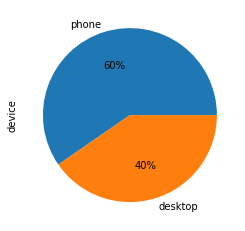

In [22]:
(part_1_data['device'].value_counts(normalize=True)*100).plot(kind='pie' , autopct='%1.0f%%' )

Here we find that we have 60% of keywords are for phone users and 40% for desktop users

So let's see how ROAS varies across device category

In [0]:
ROAS_per_Device=part_1_data.groupby(['device'])['revenue','cost'].sum().reset_index()

In [0]:
ROAS_per_Device['ROAS']=ROAS_per_Device['revenue']/ROAS_per_Device['cost']

In [25]:
ROAS_per_Device

,device,revenue,cost,ROAS
0,desktop,40511.0,76541.26,0.529270
1,phone,137876.7,119131.65,1.157347


We see that ROAS seems higher for phone users, but let's check this statistically :

We need here to apply significance test for difference in average between ROAS among hone and desktop users.

First we check normality of distribution of ROAS so we can apply t - test

We use distribution plot to visualize distribution of ROAS , and shapiro test for normality

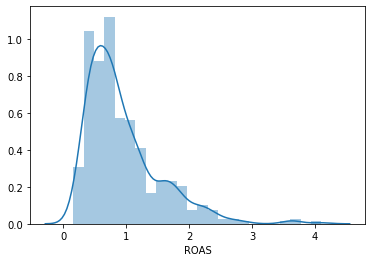

In [26]:
sns.distplot(part_1_data['ROAS'])

checking normality of ROAS generally

In [27]:
stats.shapiro(np.log(part_1_data['ROAS']))

(0.993861973285675, 0.05028387904167175)

checking normality of ROAS among desktop users

In [28]:
stats.shapiro(part_1_data.loc[part_1_data['device']=='desktop' , ['ROAS']])

(0.968809962272644, 0.000269997282885015)

checking normality of ROAS among phone users

In [29]:
stats.shapiro(part_1_data.loc[part_1_data['device']=='phone' , ['ROAS']])

(0.9024972915649414, 1.307144171548702e-12)

we see that p - value for all is less than 0.1 , also distribution of ROAS seems highly skewed to the right , so  to test if the mean of ROAS varies significantly between devices we need log transformation.

#### Now we test whether ROAS is normal for both device categories 

In [30]:
stats.shapiro(np.log(part_1_data.loc[part_1_data['device']=='phone' , ['ROAS']]))

(0.9966021776199341, 0.8059044480323792)

In [31]:
stats.shapiro(np.log(part_1_data.loc[part_1_data['device']=='desktop' , ['ROAS']]))

(0.9884333610534668, 0.11863773316144943)

So p - value is less than 0.1 , so we can not reject that ROAS isnormal for both device categories after taking log transformation.

Now we run the test

In [32]:
stats.ttest_ind(np.log(part_1_data.loc[part_1_data['device']=='phone' , ['ROAS']]),np.log(part_1_data.loc[part_1_data['device']=='desktop' , ['ROAS']]))

Ttest_indResult(statistic=array([17.59386619]), pvalue=array([9.62945169e-54]))

So we find that average of ROAS is higher in case of Device is phone than in case of desktop devices , 

#### So, we can try to improve ROAS rate , if we make traffic depends more on phone devices users.

#### Then let's check by country

so we check first which country hs the largest portion of traffic.

In [33]:
np.round(part_1_data['country'].value_counts(normalize=True)*100,2)


US         53.14
Germany    23.43
Spain      12.34
France     11.09
Name: country, dtype: float64

we see that US has the largest portion with more than 50% of traffic.

Then we see how countries vary as per average of ROAS.

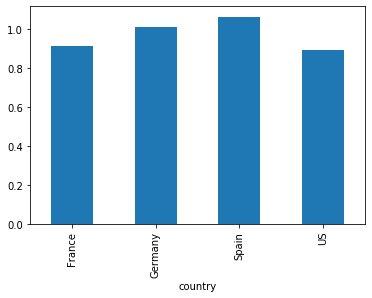

In [34]:
part_1_data.groupby(['country'])['ROAS'].mean().plot(kind='bar')

Here we notice that differences between countries are slight.

Let's verify that statistically, we use one way anova to see if any of the 4 country categories has a different mean than others as per LOG of ROAS ( we take log transformationto validate normality assumption)

In [35]:
stats.f_oneway(np.log(part_1_data.loc[part_1_data['country'] == 'France' ,['ROAS']]), 
             np.log(part_1_data.loc[part_1_data['country'] == 'US' ,['ROAS']]),
             np.log(part_1_data.loc[part_1_data['country'] == 'Spain' ,['ROAS']]),
             np.log(part_1_data.loc[part_1_data['country'] == 'Germany' ,['ROAS']]))

F_onewayResult(statistic=array([1.84964999]), pvalue=array([0.13729727]))

Since p - value is larger than 0.1 , we can not reject that ROAS mean is equal for all countries.

### So here to improve ROAS to reach our target we need to have more traffic from phone devices and that's how our traffic will change.

#### we can increase mobile friendliness of the site , this is expected to make more traffic from mobile device users , also we can refine keywords targeting to attract our direct target customers, this will get higher clicks from specific keywords than others

#### for more ways to improve ROAS check that article: https://www.visiture.com/blog/a-tactical-cheat-sheet-to-improving-your-ppc-roas/

### C) Tracked click-outs are a subset of click-outs for which we know what happens afterward
###with the booking on the hotel booking site that the user is redirected to.
###• Why do you think the tracking coverage is below 100%?
###• Why do you think the tracking coverage varies with every keyword?

first we have a quick brief about the variability in tracking coverage 

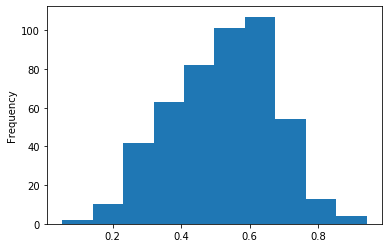

In [36]:
part_1_data['tracking_coverage'].plot(kind='hist')

### • we see that it is less than 1 , this is because of bounce rate , not all clickouts are tracked , since a lot of users click on the link that drives to advertiser website , then closes without any activity to track 

#### • The tracked clickout percent is not the same for all keywords, since some keywords are directly about what a customer needs like "Hotels in Egypt".
#### these  are expected to have a higher tracked clickouts percentage  . since once a user searches this keyword , clicks on trivago , he finds ads about hotels in Egypt , he goes to advertiser site , browse prices and do some activity to track.
#### unlikely, some other keywords are more general like like "Life in Egypt" which is not direct enough , and it is not guarnteed that the browser who searches this keyword is really a visitor who plans to visit Egypt, so if he clicks a link to the advertiser website , he may close it without any activity
### For the above reasons  not all keywords have the same tracking coverage

### D) Would you trust the booking value per tracked click-out (BVPtCO) from every keyword the same?

since we will work on keyword as our unit  , we will group our data by keyword , recalculate averages for keyword as a unit.

In [0]:
part_1_data_k = part_1_data.merge(total_clicks_Revenue , on=['keyword_id']).groupby(['keyword_id','device']).sum()

In [0]:
part_1_data_k['tracking_coverage'] = part_1_data_k['tracked_clickouts'] / part_1_data_k['total_clickouts']
part_1_data_k['CPC'] = part_1_data_k['cost'] / part_1_data_k['clicks']
part_1_data_k['ROAS'] = part_1_data_k['revenue'] / part_1_data_k['tracked_clickouts']



then we calculate , booking value per tracked click-out (BVPtCO) as booking_value / tracked_clickouts

In [0]:
part_1_data_k['BVPtCO'] = part_1_data_k['booking_value'] / part_1_data_k['tracked_clickouts']

then we have a quick impression about its distribution, 

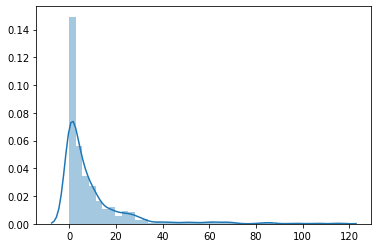

In [40]:
sns.distplot(part_1_data_k.loc[part_1_data_k['tracked_clickouts'] > 0,['BVPtCO']])

as we find , it is highly skewed to the right, indicating presense of outliers.

We needto judge what affects (BVPtCO) so we can not trust it equally for all keywords as an indicator for quality for all keywords

In [41]:
part_1_data_k.loc[part_1_data_k['tracked_clickouts'] > 0].corr()['BVPtCO']

cost                  -0.011144
clicks                -0.127875
revenue               -0.109219
CPC                    0.511224
ROAS                   0.187999
total_clickouts       -0.117063
tracked_clickouts     -0.105362
tracking_coverage     -0.093520
booking_value          0.301714
revenue_per_keyword   -0.037006
clicks_per_keyword    -0.075806
RPC                    0.294295
BVPtCO                 1.000000
Name: BVPtCO, dtype: float64

#### Here we find that the most correlated feature with (BVPtCO) is CPC cost per click , so (BVPtCO) doesn't reflect quality of keyword , so the more Trivago spends on keyword to be more viewed ,  (BVPtCO) gets better. As clear from the scatter plot below.



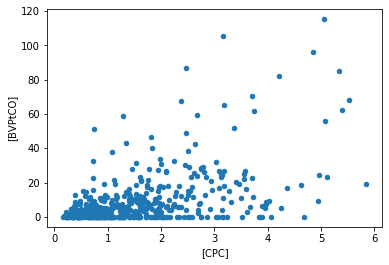

In [42]:
part_1_data_k.loc[part_1_data_k['tracked_clickouts'] > 0].plot(kind='scatter' , y=['BVPtCO'] , x=['CPC'])

#### Also, tracking coverage makes meaningfulness of  (BVPtCO) differs per keyword. the more the clickouts of the keyword are tracked , the more (BVPtCO) gets really meaningful and not biased.

#### Consider that the correlation between (BVPtCO) and tracking coverage is negative , despite it is a weak correlation ( -0.093520) but this gives an intuition that it we may have a keyword with only a one tracked keyword , but it may by chance have a large booking value.



In [43]:
part_1_data_k.sort_values(['tracking_coverage'] , ascending=True).head()

cost  clicks  ...       RPC     BVPtCO
keyword_id   device                   ...                     
1546094461   desktop  210.51     111  ...  0.530811   0.000000
297138567070 desktop  245.63      63  ...  1.380314   0.000000
438534601    phone    528.60     514  ...  1.082568   2.045455
403090956    phone    202.38     247  ...  1.306397   0.000000
             desktop  273.88     111  ...  1.306397  86.666667

[5 rows x 13 columns]

#### Here , the keyword '403090956' with desktop device despite the low (tracking_coverage) 0.19 but we have a high (BVPtCO) is high 86.666

#### So we can state that meaningfulness of (BVPtCO) differs per keyword. the more the clickouts of the keyword are tracked , the more (BVPtCO) gets really meaningful and not biased.

### For the above reasons , we can not trust (BVPtCO) from every keyword the same.



### e) Google provides performance reporting segmented by device. Device is either desktop or
###phone.
###• Create a short report of your key observations about the performance of these different devices.
###• Do they perform as you would expect?
###• Assume you are able to apply device bid modifiers. How would you calculate the modifiers and what do you expect to happen after applying them?

In [0]:
part_1_data= part_1_data.merge(total_clicks_Revenue , on=['keyword_id'])

In [0]:
part_1_data['BVPtCO'] = part_1_data['booking_value'] / part_1_data['tracked_clickouts']


we first see how kewwords are distributed among devices

In [0]:
part_1_data_k.reset_index(level=['device'] , inplace=True)

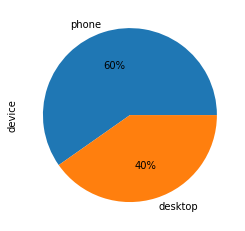

In [47]:
(part_1_data_k['device'].value_counts(normalize=True)*100).plot(kind='pie' , autopct='%1.0f%%' )

As we see , 60% of keywords are for phone devices and 40% are for desktop.

Below we will see how the main indicators differ across device categories 

We have the indicators ('tracking_coverage' ,'ROAS','clicks' ,'booking_value' , 'RPC', 'CPC' , 'BVPtCO')

We will have bar chart for mean of each indicator, followed by independent sample t - test for the mean of the indicator across device categories after taking log transformation.

We already had discussed ROAS and we proved that there is  difference in favour of phone devices , and to increase ROAS generally we need to make more traffic from phone devices.


 
average tracking_coverage per device type


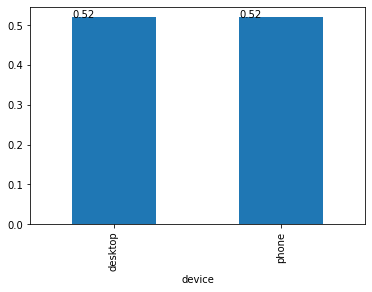

average tracking_coverage is not different significantly per device type
 
_____________________
 
average clicks per device type


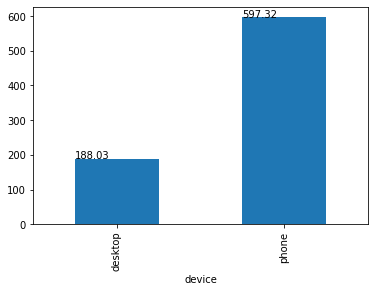

average clicks is different significantly per device type
 
_____________________
 
average booking_value per device type


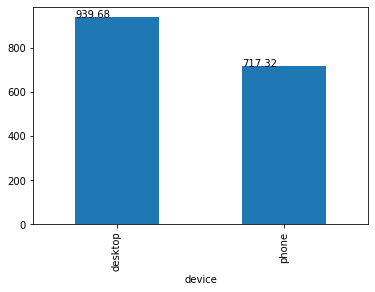

average booking_value is different significantly per device type
 
_____________________
 
average RPC per device type


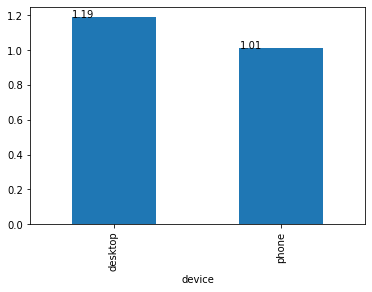

average RPC is different significantly per device type
 
_____________________
 
average CPC per device type


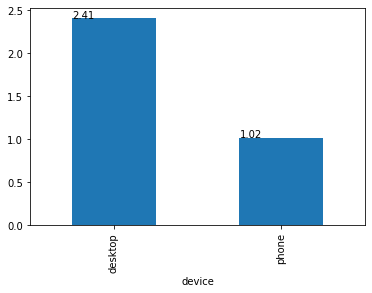

average CPC is different significantly per device type
 
_____________________
 
average BVPtCO per device type


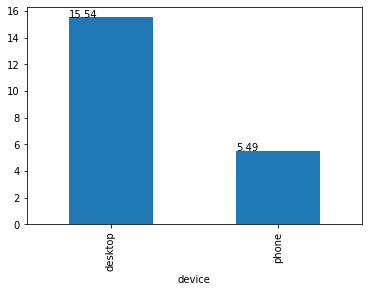

average BVPtCO is different significantly per device type
 
_____________________


In [48]:
 
for  i in ['tracking_coverage' ,'clicks' ,'booking_value' , 'RPC', 'CPC' , 'BVPtCO'] : 
     print(' ')
     print("average " + i + " per device type")
     ax = np.round((part_1_data.groupby(['device'])[i].agg('mean')),2).plot(kind='bar')
     for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.0, p.get_height() * 1.0))
     plt.show()
     if (stats.ttest_ind(np.log(part_1_data.loc[part_1_data['device']== 'phone' ,i]) , np.log(part_1_data.loc[part_1_data['device']== 'desktop' ,i] ) )[1]) > 0.1 :
        print ( "average " + i + " is not different significantly per device type" )
     else : 
      print ( "average " + i + " is different significantly per device type" )
     print(' ')

     print('_____________________')

                                                                                             
     
  


Now we see that : 

1- Average tracking coverage is not significantly different between the 2 device types.

2 - We notice that regarding average number of Clicks phone is significantly higher.

3 - We notice that , desktop is significantly higher regarding average booking value , revenue per click , cost per click (but higher in cose more than in revenue , so ROAS is higher for phone devices) , and finally BVPtCO .

### From the above result we see that phone devices bring more clicks with higher revenue than average (so it has higher ROAS) but regarding bookings , conversion (which is the thing we care about and the reason that makes advertiser pay trivago) we notice that desktop devices perform better.

### So , unexpectedly , phone devices don't perform so far away better than desktop devices. Despite it may appear that we lose regarding (ROAS).

### Write a SQL query to give the target hitting accuracy per market per device the target ROAS is provided in Sheet 2).

In [0]:
q2 = """SELECT  country , device,  ROUND((sum(revenue)*100/sum(cost)),2) as ROAC FROM part_1_data group by country , device"""

target=pd.DataFrame(ps.sqldf(q2, locals()))

In [50]:
target

,country,device,ROAC
0,France,desktop,57.26
1,France,phone,107.32
2,Germany,desktop,61.52
3,Germany,phone,126.70
4,Spain,desktop,51.85
5,Spain,phone,145.49
6,US,desktop,47.78
7,US,phone,104.98


## Part 2 : A/B Testing

### Task 1 ) This time the bidding team came up with an algorithm based on a strategy to drive more traffic to the website through the Search Engine Marketing (SEM) ads. You will find a list of keyword IDs with some of the metrics per keyword. Come up with a test-control split that the team can go ahead with to launch the live test. You are free to make assumptions to guide your decisions.

we first have a quick brief about how data is structured.

In [51]:
part_2_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 9 columns):
Market Code           896 non-null object
City criteria name    896 non-null object
Keyword ID            896 non-null int64
Clicks                896 non-null int64
Cost                  896 non-null float64
Revenue               896 non-null float64
Clickouts             896 non-null int64
Bookings              896 non-null float64
Booking Value         896 non-null float64
dtypes: float64(4), int64(3), object(2)
memory usage: 63.1+ KB


every single columns not containing missing values  , but we need to change columns names to be more compatible with python 

In [0]:
part_2_data.columns = ['market_code' , 'city_criteria_name' ,'keyword_id' , 'clicks' , 'cost' ,'revenue' , 'clickouts' , 'bookings' ,'booking_value']

then we save keyword_ID as string since it is a unique identifier not a scale variable

In [0]:
part_2_data['keyword_id'] = part_2_data['keyword_id'].astype('str')

then we have  a quick view on data

In [54]:
part_2_data.head()

,market_code,city_criteria_name,keyword_id,clicks,cost,revenue,clickouts,bookings,booking_value
0,UK,unmatched,10001,1439145,900982.47,910388.87,808801,16647.400950,5.004265e+06
1,UK,London,10002,368019,267249.99,246334.50,210164,4514.063348,1.565522e+06
2,UK,Birmingham,10003,75253,47124.14,48313.32,43642,840.912914,1.755663e+05
3,UK,Glasgow,10004,58068,35655.06,36295.92,32571,531.473714,1.575939e+05
4,UK,Liverpool,10005,53332,32190.95,32944.39,29847,447.501815,1.238864e+05


For A/B test we need to divide key words into 2 equal sets that in which the distribution of main variable is not different.

We assume that the distribtion of main variables is the normal distribution , especially that we have a large enough sample.

we use train_test_split method from sklearn package to divide keywords into test set and control set

In [0]:
test_data2 , control_data2 = train_test_split(part_2_data ,test_size=0.5,  shuffle=True)

In [56]:
test_data2.describe()

,clicks,cost,revenue,clickouts,bookings,booking_value
count,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000
mean,2778.330357,1746.738973,1756.706786,1572.345982,31.553362,9064.522766
std,5486.753781,3454.183716,3469.341036,3142.482676,64.132908,16605.042376
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,411.750000,270.030000,260.515000,232.000000,4.618435,779.915866
50%,1223.000000,769.555000,775.135000,688.500000,14.225866,3879.184910
75%,2911.250000,1840.310000,1792.770000,1611.750000,34.114777,10927.222180
max,75253.000000,47124.140000,48313.320000,43642.000000,840.912914,175566.265255


in the following lines we wil check that for the same 

we will have distribution plot for each variable in the train and test sets 

followed by Kolmogrov amirnov test result for the similarity of distribution 

we can compare distribution of the two columns using two-sample Kolmogorov-Smirnov test, it is included in the scipy.stats: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html





    
distribution of clicks in test set


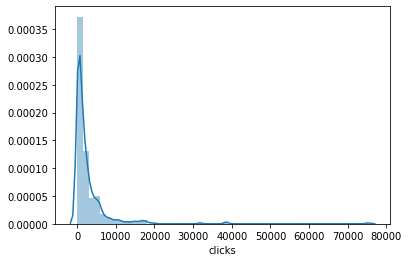

distribution of clicks in control set


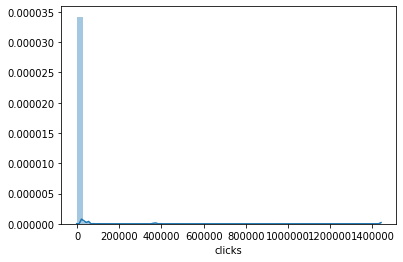

Kolmogrov smirnov test for distribution of clicks between control and test set
Ks_2sampResult(statistic=0.09344989167128533, pvalue=0.036248898808518226)
-----------------
    
distribution of cost in test set


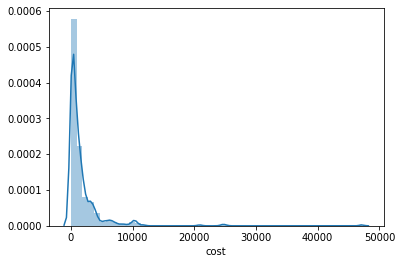

distribution of cost in control set


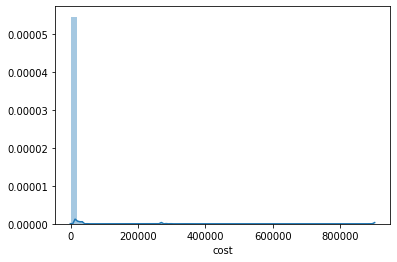

Kolmogrov smirnov test for distribution of cost between control and test set
Ks_2sampResult(statistic=0.08215347407668665, pvalue=0.089920901842377)
-----------------
    
distribution of revenue in test set


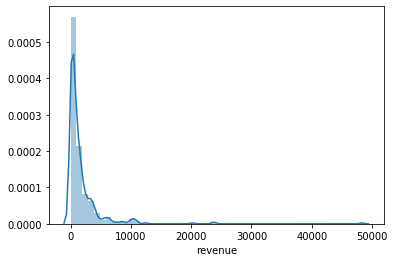

distribution of revenue in control set


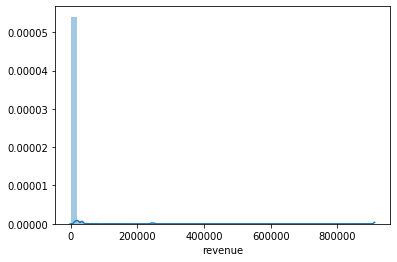

Kolmogrov smirnov test for distribution of revenue between control and test set
Ks_2sampResult(statistic=0.08495193649022244, pvalue=0.07467187709621737)
-----------------
    
distribution of clickouts in test set


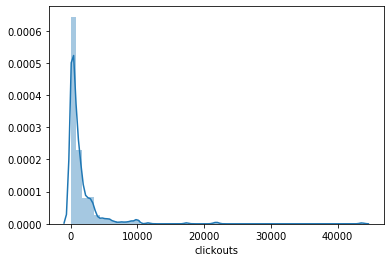

distribution of clickouts in control set


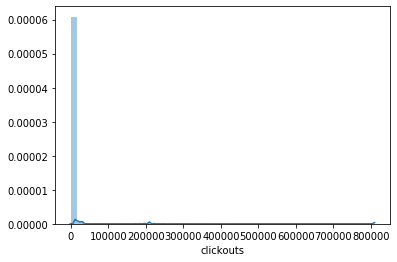

Kolmogrov smirnov test for distribution of clickouts between control and test set
Ks_2sampResult(statistic=0.08957820782712354, pvalue=0.05203768964429156)
-----------------
    
distribution of bookings in test set


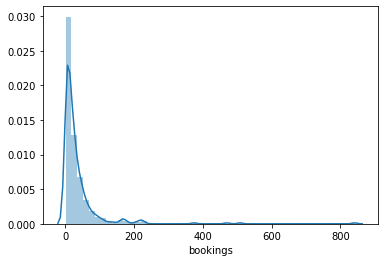

distribution of bookings in control set


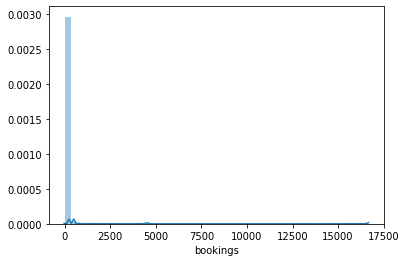

Kolmogrov smirnov test for distribution of bookings between control and test set
Ks_2sampResult(statistic=0.04768362598657994, pvalue=0.7349226201587926)
-----------------
    
distribution of booking_value in test set


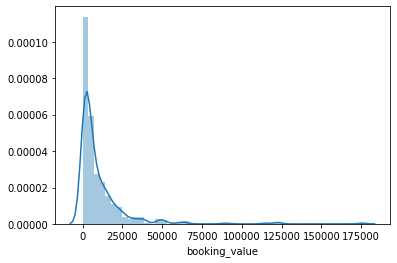

distribution of booking_value in control set


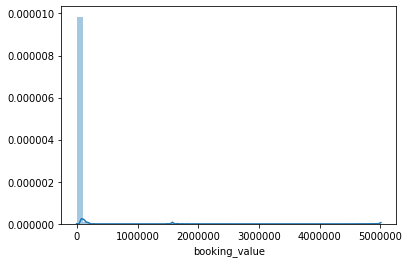

Kolmogrov smirnov test for distribution of booking_value between control and test set
Ks_2sampResult(statistic=0.05956757590559683, pvalue=0.46125110968127503)
-----------------


In [57]:
for i in ['clicks' , 'cost' ,'revenue' , 'clickouts' , 'bookings' ,'booking_value'] : 
  print('    ')
  print ('distribution of ' + i + ' in test set')
  sns.distplot(test_data2.loc[test_data2[i]> 0 , i])
  plt.show()
 
  print ('distribution of ' + i + ' in control set')
  sns.distplot(control_data2.loc[control_data2[i]>0 ,i])
  plt.show()
  
  print ('Kolmogrov smirnov test for distribution of ' + i + ' between control and test set')
  print(ks_2samp(control_data2.loc[control_data2[i]>0 ,i], test_data2.loc[test_data2[i]> 0 , i]))

  print('-----------------')




From above we see that distribution plot of each variable is not different between control and test set , since for all variable p-value for kolmogrov - smirnov test is more than  0.1


### So we managed to divide keywords to 2 equal sets with distribution of main characteristics the same

### Task 2 ) a. We want to improve the quality of traffic trivago sends to the advertisers. Define the business metrics that we should look at to qualify our algorithm changes (please refer to the terminology below).

In [58]:
part_2_data.describe()

,clicks,cost,revenue,clickouts,bookings,booking_value
count,8.960000e+02,896.000000,896.000000,896.000000,896.000000,8.960000e+02
mean,4.946628e+03,3143.455413,3145.570335,2797.819196,55.886927,1.684649e+04
std,4.980906e+04,31505.885218,31621.473980,28025.787542,578.106884,1.755830e+05
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,4.577500e+02,297.650000,298.307500,259.000000,4.920492,9.818032e+02
50%,1.371000e+03,865.260000,853.070000,764.500000,15.031417,3.963855e+03
75%,3.131750e+03,1939.887500,1964.347500,1729.250000,34.492830,1.112593e+04
max,1.439145e+06,900982.470000,910388.870000,808801.000000,16647.400950,5.004265e+06


In [59]:
part_2_data.head()

,market_code,city_criteria_name,keyword_id,clicks,cost,revenue,clickouts,bookings,booking_value
0,UK,unmatched,10001,1439145,900982.47,910388.87,808801,16647.400950,5.004265e+06
1,UK,London,10002,368019,267249.99,246334.50,210164,4514.063348,1.565522e+06
2,UK,Birmingham,10003,75253,47124.14,48313.32,43642,840.912914,1.755663e+05
3,UK,Glasgow,10004,58068,35655.06,36295.92,32571,531.473714,1.575939e+05
4,UK,Liverpool,10005,53332,32190.95,32944.39,29847,447.501815,1.238864e+05


In [60]:
part_2_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 9 columns):
market_code           896 non-null object
city_criteria_name    896 non-null object
keyword_id            896 non-null object
clicks                896 non-null int64
cost                  896 non-null float64
revenue               896 non-null float64
clickouts             896 non-null int64
bookings              896 non-null float64
booking_value         896 non-null float64
dtypes: float64(4), int64(2), object(3)
memory usage: 63.1+ KB


In [61]:
part_2_data.corr()

,clicks,cost,revenue,clickouts,bookings,booking_value
clicks,1.000000,0.999265,0.999890,0.999986,0.999555,0.997841
cost,0.999265,1.000000,0.999700,0.999399,0.999460,0.999224
revenue,0.999890,0.999700,1.000000,0.999938,0.999698,0.998539
clickouts,0.999986,0.999399,0.999938,1.000000,0.999601,0.998001
bookings,0.999555,0.999460,0.999698,0.999601,1.000000,0.998821
booking_value,0.997841,0.999224,0.998539,0.998001,0.998821,1.000000


Due to high collinearity here , we can find that all features are importent to be included to qualify our algorithm changes.

let's try to calculate and addother features that were in the first part'sdata

In [0]:
part_2_data['ROAS'] = part_2_data['revenue']/part_2_data['clicks']

In [0]:
part_2_data['BApCO'] = part_2_data['booking_value']/part_2_data['clickouts']

In [0]:
part_2_data['CPC'] = part_2_data['cost']/part_2_data['clicks']

In [0]:
part_2_data['clickout_rate'] = part_2_data['clickouts']/part_2_data['clicks']

In [0]:
part_2_data['average_booking_value'] = part_2_data['booking_value']/part_2_data['bookings']

then we use principal component analysis to find the most importent features to focus on.

In [0]:
predictors = part_2_data.select_dtypes(include=['int','float']).dropna()

In [0]:
index = part_2_data.select_dtypes(include=['int','float']).columns

In [0]:
transformer = PCA(n_components=3 ,random_state=0)

In [0]:
fit=transformer.fit(predictors)

In [71]:
np.round(fit.explained_variance_ratio_*100,2)

array([9.996e+01, 4.000e-02, 0.000e+00])

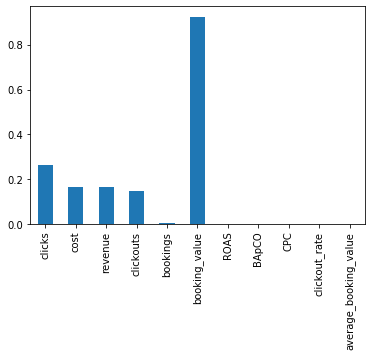

In [72]:
pd.Series ((fit.components_)[0] , index=index).plot(kind='bar')


###So here , due to high collinearity the most importent feature to focus on is booking_value

### Task 2) b. Now the team launched a new test to improve the traffic quality trivago sends to the advertisers. In the resources, you will find test statistics. With the metrics defined above, how would you go about evaluating this test. What would your proposal be for the next steps?

We see that recults regarding Conversion Rate ,Bounce Rate , and BApCO have p - valueof 0.2 or more. so we find them nonsignificant.

On the other hand , clickouts  decreased by 5.4% and revenue per visits by 1.2% with p - values of 0.01 and 0.04 respecrively , indicating that this decrease is significant.

### So we see that 2 of the key features had decreased after launching the new test. so we see that the current version (control version) is OK andthe new test version gives significantly lesser results in 2 key features.

###Finally we export required results to excel sheets

In [0]:
with pd.ExcelWriter('submission.xlsx') as writer:  
   np.round(total_clicks_Revenue.sort_values(by=['RPC'] , ascending=False).head(10),2)['RPC'].to_excel(writer , sheet_name = 'business_metrics_a')
   target.to_excel(writer ,sheet_name = 'business_metrics_e')
   control_data2.to_excel(writer , sheet_name = 'A_B testing_task_1_control_data')
   test_data2.to_excel(writer ,   sheet_name = 'A_B testing_task_1_test_data')